In [33]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Set paths for local environment
BASE_DIR = "melanoma_cancer_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [37]:
print("Dataset paths:")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test directory exists: {os.path.exists(TEST_DIR)}")

Dataset paths:
Train directory: melanoma_cancer_dataset\train
Test directory: melanoma_cancer_dataset\test
Train directory exists: True
Test directory exists: True


In [38]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [39]:
# Only rescaling for validation/test
test_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

Found 9605 images belonging to 2 classes.


In [41]:
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 1000 images belonging to 2 classes.


In [42]:
print("Class Mapping:", train_generator.class_indices)
print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Class Mapping: {'benign': 0, 'malignant': 1}
Training samples: 9605
Test samples: 1000


In [43]:
def plot_sample_images(generator, title="Sample Images"):
    """Plot sample images from the generator"""
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        class_name = "Malignant" if labels[i] == 1 else "Benign"
        plt.title(f"{class_name}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

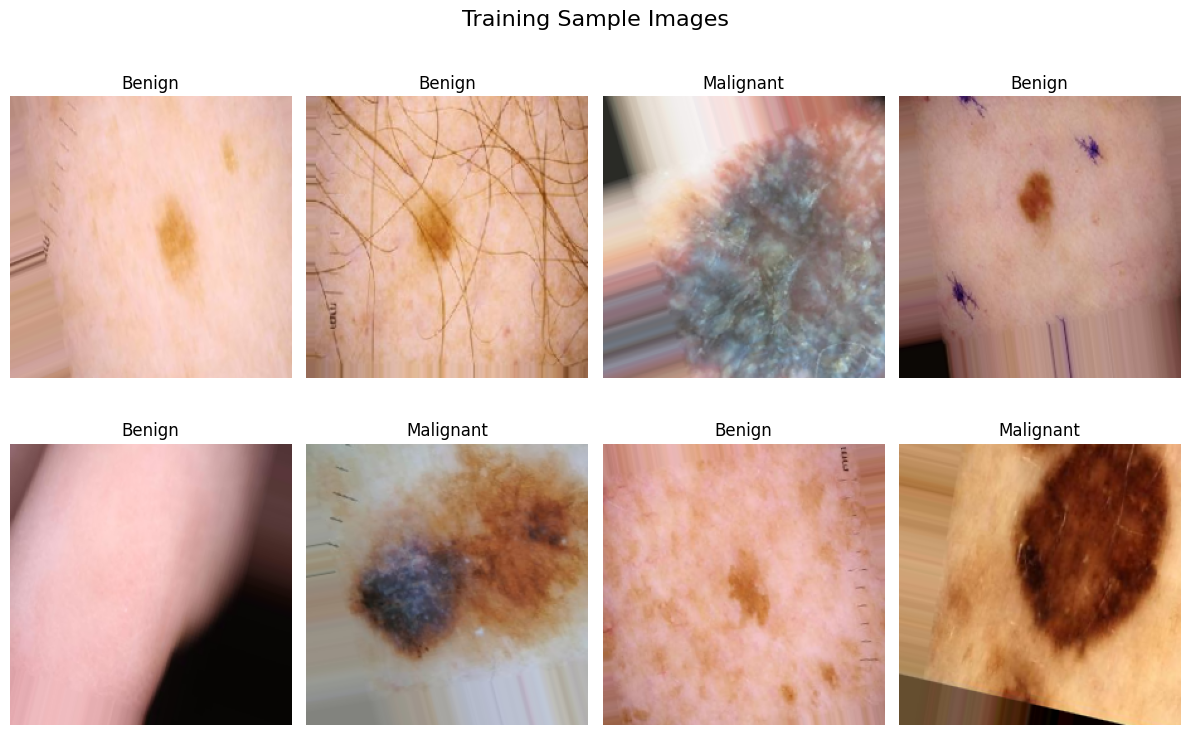

In [44]:
# Plot sample images
plot_sample_images(train_generator, "Training Sample Images")

In [45]:
def create_mobilenetv2_model():
    """Create MobileNetV2 based model for skin cancer detection"""
    
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [46]:
# Create the model
print("Creating MobileNetV2 model...")
model = create_mobilenetv2_model()

Creating MobileNetV2 model...


In [47]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [48]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [49]:
# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

In [50]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [51]:
model_checkpoint = ModelCheckpoint(
    'skin_cancer_mobilenetv2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [52]:
# Train the model
print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=1
)

Starting model training...
Epoch 1/20
300/300 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8340
Epoch 1: val_accuracy improved from -inf to 0.89113, saving model to skin_cancer_mobilenetv2.h5
300/300 [==============================] - 329s 1s/step - loss: 0.3886 - accuracy: 0.8340 - val_loss: 0.2473 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8592
Epoch 2: val_accuracy did not improve from 0.89113
300/300 [==============================] - 189s 628ms/step - loss: 0.3267 - accuracy: 0.8592 - val_loss: 0.2771 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 3/20
300/300 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.8687
Epoch 3: val_accuracy improved from 0.89113 to 0.91129, saving model to skin_cancer_mobilenetv2.h5
300/300 [==============================] - 154s 512ms/step - loss: 0.3087 - accuracy: 0.8687 - val_loss: 0.2376 - val_accuracy: 0.9113 - lr: 0.001

In [65]:
model.save("skin_cancer_mobilenetv2_final.h5")

In [54]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

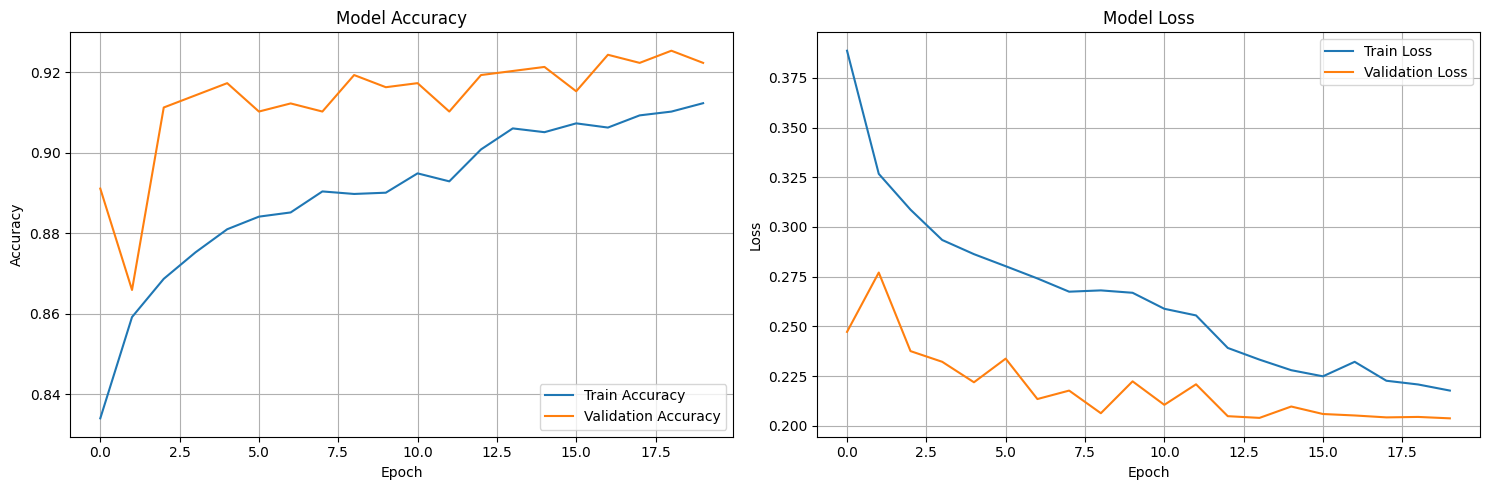

In [55]:
# Plot training history
plot_training_history(history)

In [56]:
# Evaluate the model
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluating model on test set...
32/32 [==============================] - 4s 108ms/step - loss: 0.2140 - accuracy: 0.9180
Test Accuracy: 0.9180
Test Loss: 0.2140


In [57]:
# Make predictions on test set
print("Making predictions on test set...")
test_pred = model.predict(test_generator, verbose=1)
test_pred_labels = (test_pred > 0.5).astype("int32").flatten()

Making predictions on test set...
32/32 [==============================] - 6s 117ms/step


In [58]:
# Get true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]

In [59]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, 
                          target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.96      0.92       500
   Malignant       0.96      0.87      0.91       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



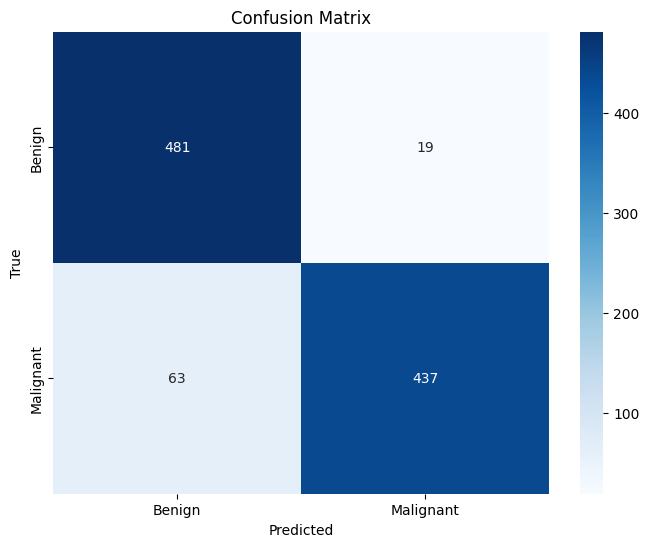

In [60]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Function to predict on single images
def predict_skin_cancer_single(image_path, model):
    """Predict skin cancer on a single image"""
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)
    probability = float(prediction[0][0])
    class_label = "Malignant" if probability > 0.5 else "Benign"
    
    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {class_label} (Confidence: {probability:.2%})")
    plt.axis("off")
    plt.show()
    
    return class_label, probability

Testing predictions on sample images...
Testing benign image: melanoma_cancer_dataset\test\benign\melanoma_10000.jpg
1/1 [==============================] - 2s 2s/step


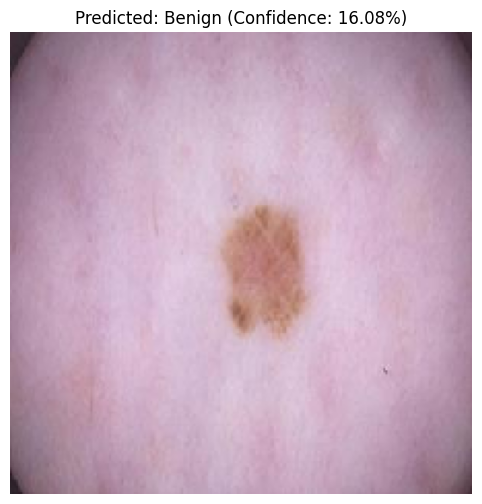

Testing malignant image: melanoma_cancer_dataset\test\malignant\melanoma_10105.jpg
1/1 [==============================] - 0s 46ms/step


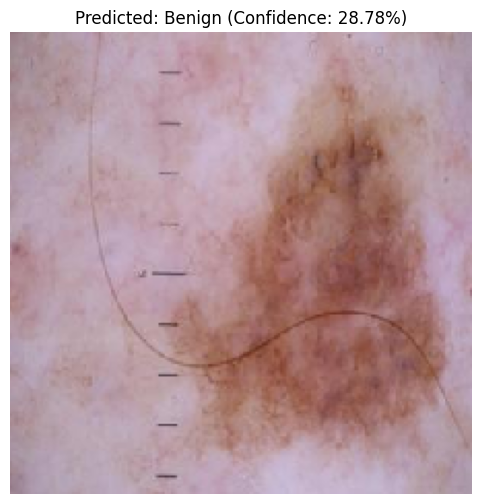

Training completed successfully!
Model saved as 'skin_cancer_mobilenetv2.h5'


In [63]:
# Test prediction on sample images
print("Testing predictions on sample images...")
try:
    # Try to find some test images
    test_benign_path = os.path.join(TEST_DIR, "benign")
    test_malignant_path = os.path.join(TEST_DIR, "malignant")
    
    if os.path.exists(test_benign_path):
        benign_files = [f for f in os.listdir(test_benign_path) if f.endswith('.jpg')]
        if benign_files:
            sample_benign = os.path.join(test_benign_path, benign_files[0])
            print(f"Testing benign image: {sample_benign}")
            predict_skin_cancer_single(sample_benign, model)
    
    if os.path.exists(test_malignant_path):
        malignant_files = [f for f in os.listdir(test_malignant_path) if f.endswith('.jpg')]
        if malignant_files:
            sample_malignant = os.path.join(test_malignant_path, malignant_files[0])
            print(f"Testing malignant image: {sample_malignant}")
            predict_skin_cancer_single(sample_malignant, model)
            
except Exception as e:
    print(f"Could not test sample predictions: {e}")

print("Training completed successfully!")
print("Model saved as 'skin_cancer_mobilenetv2.h5'")